In [1]:
import pandas as pd
import numpy as np
import warnings
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.base import clone
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 10
N_REPEATS = 5

# Loading and Processing Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')

train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = train.drop(columns='Rings')
y = train['Rings']

# Training Base Models

In [4]:
def train(regressor, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    model = TransformedTargetRegressor(
        regressor=regressor,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    oof_preds = np.zeros(len(X), dtype=float)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        y_pred = np.zeros_like(y_val, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                m.regressor.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_pred += m.predict(X_val)
            
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)
        
        score = mean_squared_log_error(y_val, y_pred, squared=False)
        scores.append(score)        
        oof_preds[val_idx] = y_pred
    
    return scores, oof_preds

def predict(regressor, X, y, X_test, n_repeats=N_REPEATS):
    model = TransformedTargetRegressor(
        regressor=regressor,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    y_pred = np.zeros(len(X_test), dtype=float)
    for i in range(n_repeats):
        m = clone(model)
        if n_repeats > 1:
            m.regressor.set_params(random_state=i)
        m.fit(X, y)
        y_pred += m.predict(X_test)
    y_pred /= n_repeats
    y_pred = y_pred.clip(1, 29)
    return y_pred

In [5]:
xgb_params = {
    'n_jobs': -1,
    'max_depth': 6,
    'n_estimators': 1942,
    'random_state': SEED,
    'min_child_weight': 1,
    'gamma': 0.03564293452391207,
    'subsample': 0.6956271823055759,
    'reg_alpha': 0.7236848478280202,
    'reg_lambda': 0.6760094001242347,
    'learning_rate': 0.04328457758575266,
    'colsample_bynode': 0.962341555268564,
    'colsample_bytree': 0.7506537997746077,
    'colsample_bylevel': 0.8727635788126956,
}

cb_params = {
    'depth': 15, 
    'verbose': 0,
    'max_bin': 464, 
    'verbose': False,
    'random_state':SEED,
    'task_type': 'CPU', 
    'random_state': SEED,
    'eval_metric': 'RMSE', 
    'min_data_in_leaf': 78, 
    'loss_function': 'RMSE', 
    'grow_policy': 'Lossguide', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.83862137638162, 
    'l2_leaf_reg': 8.365422739510098, 
    'random_strength': 3.296124856352495, 
    'learning_rate': 0.09992185242598203,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 20,
    'num_leaves': 165,
    'subsample_freq': 1,
    'random_state': SEED,
    'n_estimators': 1460,
    'min_child_samples': 25,
    'reg_lambda': 6.13475387151606,
    'subsample': 0.8036874216939632,
    'reg_alpha': 0.3152990674231573,
    'learning_rate': 0.009336479469693189,
    'colsample_bytree': 0.5780931837049811,
    'min_child_weight': 0.37333232256934057,
}

gb_params = {
    'max_depth': 7,
    'random_state': SEED,
    'n_estimators': 1520,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'subsample': 0.8386058289444608,
    'learning_rate': 0.021568657897174062,
}

In [6]:
xgb_model = XGBRegressor(**xgb_params)
xgb_scores, xgb_oof_preds = train(xgb_model, X, y)
print(f'XGB:    {np.mean(xgb_scores)}')

cb_model = CatBoostRegressor(**cb_params)
cb_scores, cb_oof_preds = train(cb_model, X, y)
print(f'CB:     {np.mean(cb_scores)}')

lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_scores, lgbm_oof_preds = train(lgbm_model, X, y)
print(f'LGBM:   {np.mean(lgbm_scores)}')

gb_model = GradientBoostingRegressor(**gb_params)
gb_scores, gb_oof_preds = train(gb_model, X, y)
print(f'GB:     {np.mean(gb_scores)}')

XGB:    0.14828680025204577
CB:     0.1475879632917944
LGBM:   0.1477611444102072
GB:     0.14779814346857467


# Ensembling Base Learners

In [7]:
estimators = [
    ('xgb', xgb_model),
    ('cb', cb_model),
    ('lgbm', lgbm_model),
    ('gb', gb_model)
]

In [8]:
# def objective(trial):
#     params = {
#         'xgb_weight': trial.suggest_float('xgb_weight', 0.0, 1.0),
#         'cb_weight': trial.suggest_float('cb_weight', 0.0, 1.0),
#         'lgbm_weight': trial.suggest_float('lgbm_weight', 0.0, 1.0),
#         'gb_weight': trial.suggest_float('gb_weight', 0.0, 1.0),
#     }

#     weights = [
#         params['xgb_weight'],
#         params['cb_weight'],
#         params['lgbm_weight'],
#         params['gb_weight']
#     ]
#     weights /= np.sum(weights)

#     voter = VotingRegressor(estimators=estimators, weights=weights, n_jobs=-1)
#     scores, _ = train(voter, X, y, 1)
    
#     return np.mean(scores)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1000)

# best_weights = study.best_params
# weights = [
#     best_weights['xgb_weight'],
#     best_weights['cb_weight'],
#     best_weights['lgbm_weight'],
#     best_weights['gb_weight']
# ]

# weights /= np.sum(weights)
# print(f'\nBest Weights: {list(weights)}')

weights = [0.18844250545656566, 0.6422423960522606, 0.1688203675689123, 0.0004947309222612189]

In [9]:
voter = VotingRegressor(estimators=estimators, weights=weights, n_jobs=-1)
voter_scores, oof_preds = train(voter, X, y, N_SPLITS, 1)

print(f'Ensemble: {np.mean(voter_scores)}')

Ensemble: 0.14761931025167493


# Results

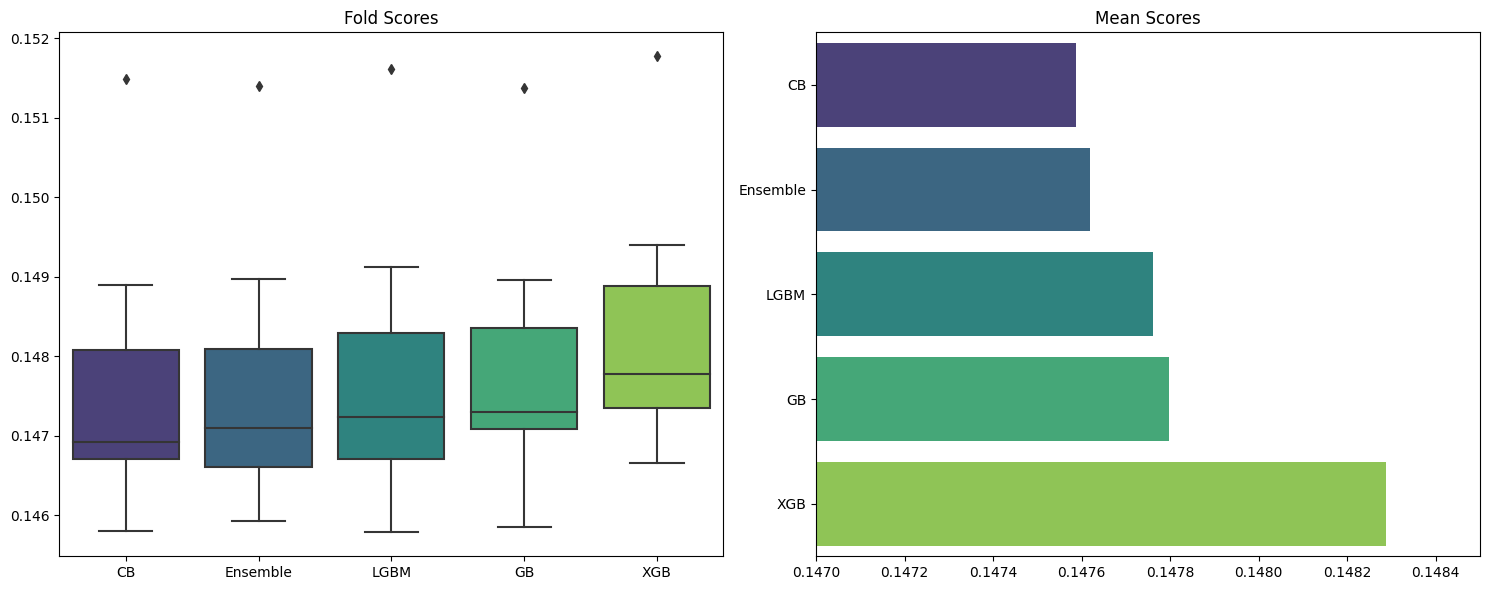

In [10]:
scores = pd.DataFrame({
    'XGB': xgb_scores,
    'CB': cb_scores,
    'LGBM': lgbm_scores,
    'GB': gb_scores,
    'Ensemble': voter_scores
})
scores = scores[scores.mean().sort_values().index]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(data=scores, ax=axes[0], palette='viridis')
axes[0].set_title('Fold Scores')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
mean_scores = scores.mean().sort_values()
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=axes[1], palette='viridis')
axes[1].set_title('Mean Scores')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim(left=0.147, right=0.1485)
plt.tight_layout()
plt.show()

# Blending Results

In [11]:
y_pred = predict(voter, X, y, test, 1)
voter_sub = pd.DataFrame({'id': test.index, 'Rings': y_pred})
voter_sub.to_csv(f'xgb_cb_lgbm_gb_ensemble.csv', index=False)
voter_sub.head()

,id,Rings
0,90615,9.644732
1,90616,9.729330
2,90617,9.912553
3,90618,10.315910
4,90619,7.562928


In [12]:
public_lb_best_sub = pd.read_csv('/kaggle/input/ps4e4-prediction-generalization-regression/submission.csv')["Rings"].values
ensemble_sub = voter_sub["Rings"].values

ensemble_lb_sub = voter_sub.copy()
ensemble_lb_sub["Rings"] = np.average(np.c_[public_lb_best_sub, ensemble_sub], axis=1, weights=[0.9, 0.1])
ensemble_lb_sub["Rings"] = ensemble_lb_sub["Rings"].clip(1, 29)
ensemble_lb_sub["Rings"] = np.where(ensemble_lb_sub["Rings"].between(27.5, 29), 29, ensemble_lb_sub["Rings"])
ensemble_lb_sub.to_csv(f'xgb_cb_lgbm_gb_ensemble-public_lb_best.csv', index=False)
ensemble_lb_sub.head()

,id,Rings
0,90615,9.715992
1,90616,9.690236
2,90617,9.698754
3,90618,10.540567
4,90619,7.593871


In [13]:
classifier_sub = pd.read_csv('/kaggle/input/s04e04-abalone-age-prediction-classification/xgb_cb_ensemble.csv')["Rings"].values

ensemble_lb_classifier_sub = voter_sub.copy()
ensemble_lb_classifier_sub["Rings"] = np.average(np.c_[public_lb_best_sub, ensemble_sub, classifier_sub], axis=1, weights=[0.8, 0.1, 0.1])
ensemble_lb_classifier_sub["Rings"] = ensemble_lb_classifier_sub["Rings"].clip(1, 29)
ensemble_lb_classifier_sub["Rings"] = np.where(ensemble_lb_classifier_sub["Rings"].between(27.5, 29), 29, ensemble_lb_classifier_sub["Rings"])
ensemble_lb_classifier_sub.to_csv(f'xgb_cb_lgbm_gb_ensemble-public_lb_best-classifier.csv', index=False)
ensemble_lb_classifier_sub.head()

,id,Rings
0,90615,9.725970
1,90616,9.703620
2,90617,9.724928
3,90618,10.521546
4,90619,7.597355
